In [1]:
###########################################
## 코드가 돌아가는데 매우 오래걸립니다... 이해해주시면 감사하겠습니다.
## lg gram / i5 8세대 기준으로 약 32분이 걸렸습니다
###########################################

import itertools
import json
import numpy as np
import pandas as pd
import re
import random
import operator
import math
import time
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
def load(path):
    review = []
    for line in open(path, 'r'):
        row = json.loads(line)
        review.append(row)
    return np.array(review)

##################################################

def preprocessing(sentence):
    letters = re.sub('[^a-zA-Z]', ' ', sentence)
    words_list = letters.lower().split()
    return words_list

#################################################

def from_iterable(iterables):        # Flatten list : 2D -> 1D
    for it in iterables:
        for element in it:
            yield element

##################################################

def DefaultClassifier(Train, Test, string):          # Baseline 비교용
    if string == 'isFunny':
        index = 5000
    elif string == 'isUseful':
        index = 5001
    elif string == 'isCool':
        index = 5002
    elif string == 'isPositive':
        index = 5003
        
            
    Y_1Count = 0
    for i in range(len(Train)):
        if Train[i][index] == 1:
            Y_1Count += 1                                # Y = 1의 갯수
    
    Y_1Pr = Y_1Count / len(Train)
    
    if Y_1Pr > 0.5:
        return [1 for i in range(len(Test))]
    elif Y_1Pr < 0.5:
        return [0 for i in range(len(Test))]

#####################################################

def Accuracy(predict, label):
    equal = 0
    for a, b in zip(predict, label):
            if a == b:
                equal += 1
    accuracy = equal / len(predict)
    return accuracy

#####################################################

def Error(list):
    error = []
    for i in list:
        error.append(1-i)
    return error

#####################################################
########## 1 - (a)

def Filter(data):
    FilteredData = []                      # list type
    for i in range(len(data)):
        if 2 < data[i]['votes']['funny'] + data[i]['votes']['useful'] + data[i]['votes']['cool'] < 11:
            FilteredData.append(data[i])
    return FilteredData                 #return list type

In [3]:
############ path 변경부탁드립니다.
path = "C:/Users/pkh30/Desktop/SKKU/2020-2/인공지능개론/yelp_academic_dataset_review/"
RawData = load(path+"yelp_academic_dataset_review.json")

In [4]:
with open(path+"filtered.json", 'w') as file:
    file.write(json.dumps(Filter(RawData)))       

In [5]:
FilteredData = load(path+"filtered.json")
tmp = np.array(FilteredData[0])              # 길이 1인 리스트로 싸여있기 때문에 np로 빼줌

review = []
for i in range(len(tmp)):
    review.append(tmp[i]['text'])           # review만 추출해서 리스트에 저장

Words = []                                #2D list
for i in review:
    Words.append(preprocessing(i))          # 중첩리스트에 단어들 구분해서 저장 

FlattenWords = list(itertools.chain.from_iterable(Words))     # 2d list 펼치기

result = Counter(FlattenWords)              # dict 형태로 단어 출현 빈도 세기 {'단어' : 횟수}

In [6]:
########################### 1 - (b)
Top5000 = result.most_common(5000)      # tuples in list, 1st : the / 5000th : malt 

In [7]:
def GenerateDataPoints(dictionary):           # [1, 1, 0, 1, ... 1, 0, 0] 형태의 데이터 포인트 생성 - list 형태
    global Top5000                            # input : dictionary
    
    X_variable = []
    for i in range(len(Top5000)):
        X_variable.append(Top5000[i][0])
    Y_variable = ['isFunny', 'isUeful', ' isCool', 'isPositive']
        
    review = set(preprocessing(dictionary['text']))     # list type
    
    X_counts = [0 for i in range(5000)]             # X features list
    for i in range(len(X_variable)):
        if X_variable[i] in review:
            X_counts[i] = 1
    
    Y_counts = [0 for i in range(4)]            # Y features list - binary label
    if dictionary['votes']['funny'] > 0:        # Y1 - funny / Y2 - useful / Y3 - cool / Y4 - positive
        Y_counts[0] = 1
    if dictionary['votes']['useful'] > 0:
        Y_counts[1] = 1
    if dictionary['votes']['cool'] > 0:
        Y_counts[2] = 1
    if dictionary['stars'] > 3.5:
        Y_counts[3] = 1
    
    counts = X_counts + Y_counts
    
    return counts                           # 5004 길이의 리스트 리턴, 5000개의 X, 4 개의 Y

In [8]:
def GenerateConditionalProb(Train, string):             # string : 문자열, class 지정
    
    if string == 'isFunny':
        index = 5000
    elif string == 'isUseful':
        index = 5001
    elif string == 'isCool':
        index = 5002
    elif string == 'isPositive':
        index = 5003
        
    oneVector = [1 for i in range(5000)]


    isSomething = []                                       # Y label = 1인 조건 데이터       
    for i in range(len(Train)):
        if Train[i][index] == 1:
            isSomething.append(Train[i])                 

    isSomethingCount = []
    for i in range(5000):
        cnt = 0
        for j in range(len(isSomething)):
            cnt += isSomething[j][i]
        isSomethingCount.append(cnt)                         # 출현한 갯수, 길이 5000의 벡터

    isSomethingDen = [len(isSomething)+2 for i in range(5000)]  # Laplace Smoothing 분모

    isSomethingNum = [a+b for a, b in zip(isSomethingCount, oneVector)]  # Laplace Smoothing 분자

    isSomethingPr = [a/b for a, b in zip(isSomethingNum, isSomethingDen)]    # Pr[Xi = 1 | Y = 1] 일때 조건부 확률 리스트,
                                                                              # Pr[Xi = 0 | Y = 1] = 1 - Pr[Xi = 1 | Y = 1]
    
    notSomething = []               # Y label = 0인 조건 데이터
    for i in range(len(Train)):
        if Train[i][index] == 0:
            notSomething.append(Train[i])

    notSomethingCount = []
    for i in range(5000):
        cnt = 0
        for j in range(len(notSomething)):
            cnt += notSomething[j][i]
        notSomethingCount.append(cnt)
    
    notSomethingDen = [len(notSomething)+2 for i in range(5000)]

    notSomethingNum = [a+b for a, b in zip(notSomethingCount, oneVector)]

    notSomethingPr = [a/b for a, b in zip(notSomethingNum, notSomethingDen)]   # Pr[Xi = 1 | Y = 0] 일때 조건부 확률 리스트

    return isSomethingPr, notSomethingPr, isSomething, notSomething

In [9]:
def NBC(Train, Test, string):                    # Train set / Test set : 2d list / string : indicates class
    
    isSomethingPr, notSomethingPr, isSomething, notSomething = GenerateConditionalProb(Train, string)
    
    Y_1ConditionPr = []
    for i in range(len(Test)):
        Testi = []
        for j in range(5000):
            if Test[i][j] == 1:
                Testi.append(isSomethingPr[j])
            elif Test[i][j] == 0:
                Testi.append(1-isSomethingPr[j])
        Y_1ConditionPr.append(Testi)
        
    for testi in Y_1ConditionPr:
        testi.append(len(isSomething) / len(Train))      # Y = 1 확률
        
    Y_0ConditionPr = []
    for i in range(len(Test)):
        Testi = []
        for j in range(5000):
            if Test[i][j] == 1:
                Testi.append(notSomethingPr[j])
            elif Test[i][j] == 0:
                Testi.append(1-notSomethingPr[j])
        Y_0ConditionPr.append(Testi)
        
    for testi in Y_0ConditionPr:
        testi.append(len(notSomething) / len(Train))      # Y = 0 확률
    
    Y_1LogValue = []
    for testi in Y_1ConditionPr:
        Y_1LogValue.append(sum(np.log(np.array(testi))))

    Y_0LogValue = []
    for testi in Y_0ConditionPr:
        Y_0LogValue.append(sum(np.log(np.array(testi))))

    PredictedY = []
    for a, b in zip(Y_1LogValue, Y_0LogValue):
        if a > b:
            PredictedY.append(1)
        elif a < b:
            PredictedY.append(0)
            
    return PredictedY

In [10]:
TrainSize = [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
start = time.time()

NBCAccuracyisFunny = []
DefaultAccuracyisFunny = []

NBCAccuracyisUseful = []
DefaultAccuracyisUseful = []

NBCAccuracyisCool = []
DefaultAccuracyisCool = []

NBCAccuracyisPositive = []
DefaultAccuracyisPositive = []

    
for size in TrainSize:
    
    SampleTrain = random.sample(list(tmp), size)       # 리스트 안에 dict / [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
    TrainSet = [] 
    for i in SampleTrain:
        TrainSet.append(GenerateDataPoints(i))            # random sample 추출하여 train set으로 사용
        
    
    SampleTest = random.sample(list(tmp), 8000)           # Test 는 고정
    TestSet = []                                           # 2차원 리스트
    for i in SampleTest:
        TestSet.append(GenerateDataPoints(i))
    
    
    #############################################################
    ################ Class : isFunny
    
    PredictedYisFunny = NBC(TrainSet, TestSet, 'isFunny')
    
    DefaultYisFunny = DefaultClassifier(TrainSet, TestSet, 'isFunny')
    
    LabelYisFunny = []
    for i in range(len(TestSet)):
        LabelYisFunny.append(TestSet[i][5000])
    
    NBCScoreisFunny = Accuracy(PredictedYisFunny, LabelYisFunny)
    DefaultScoreisFunny = Accuracy(DefaultYisFunny, LabelYisFunny)
    
    NBCAccuracyisFunny.append(NBCScoreisFunny)
    DefaultAccuracyisFunny.append(DefaultScoreisFunny)
    
    ############################################################
    ################ Class : isUseful
    
    PredictedYisUseful = NBC(TrainSet, TestSet, 'isUseful')
    
    DefaultYisUseful = DefaultClassifier(TrainSet, TestSet, 'isUseful')
    
    LabelYisUseful = []
    for i in range(len(TestSet)):
        LabelYisUseful.append(TestSet[i][5001])
    
    NBCScoreisUseful = Accuracy(PredictedYisUseful, LabelYisUseful)
    DefaultScoreisUseful = Accuracy(DefaultYisUseful, LabelYisUseful)
    
    NBCAccuracyisUseful.append(NBCScoreisUseful)
    DefaultAccuracyisUseful.append(DefaultScoreisUseful)
    
    ###########################################################
    ################# Class : isCool

    PredictedYisCool = NBC(TrainSet, TestSet, 'isCool')
    
    DefaultYisCool = DefaultClassifier(TrainSet, TestSet, 'isCool')
    
    LabelYisCool = []
    for i in range(len(TestSet)):
        LabelYisCool.append(TestSet[i][5002])

    
    NBCScoreisCool = Accuracy(PredictedYisCool, LabelYisCool)
    DefaultScoreisCool = Accuracy(DefaultYisCool, LabelYisCool)
    
    
    NBCAccuracyisCool.append(NBCScoreisCool)
    DefaultAccuracyisCool.append(DefaultScoreisCool)
    
    #############################################################
    ################ Class : isPositive
    
    PredictedYisPositive = NBC(TrainSet, TestSet, 'isPositive')
    
    DefaultYisPositive = DefaultClassifier(TrainSet, TestSet, 'isPositive')
    
    LabelYisPositive = []
    for i in range(len(TestSet)):
        LabelYisPositive.append(TestSet[i][5003])
    
    NBCScoreisPositive = Accuracy(PredictedYisPositive, LabelYisPositive)
    DefaultScoreisPositive = Accuracy(DefaultYisPositive, LabelYisPositive)
    
    NBCAccuracyisPositive.append(NBCScoreisPositive)
    DefaultAccuracyisPositive.append(DefaultScoreisPositive)
    
    ###############################################################
    
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1724.733387708664


[0.31475, 0.32562500000000005, 0.327875, 0.34950000000000003, 0.36675, 0.37912500000000005, 0.377375, 0.376, 0.36987499999999995, 0.366625]
[0.314875, 0.317125, 0.31275, 0.309875, 0.32525000000000004, 0.317875, 0.326875, 0.3185, 0.31962500000000005, 0.31762500000000005]


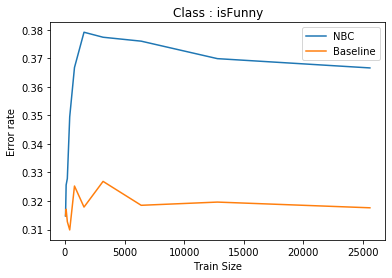

In [21]:
plt.plot(TrainSize, Error(NBCAccuracyisFunny), label = 'NBC')
plt.plot(TrainSize, Error(DefaultAccuracyisFunny), label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Error rate')
plt.title('Class : isFunny')
plt.legend()
plt.show
print(Error(NBCAccuracyisFunny))
print(Error(DefaultAccuracyisFunny))

[0.68525, 0.674375, 0.672125, 0.6505, 0.63325, 0.620875, 0.622625, 0.624, 0.630125, 0.633375]
[0.685125, 0.682875, 0.68725, 0.690125, 0.67475, 0.682125, 0.673125, 0.6815, 0.680375, 0.682375]


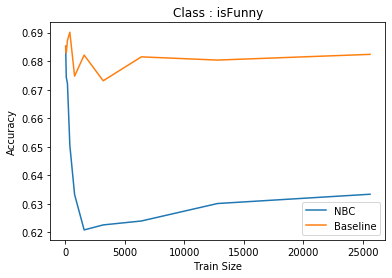

In [13]:
plt.plot(TrainSize, NBCAccuracyisFunny, label = 'NBC')
plt.plot(TrainSize, DefaultAccuracyisFunny, label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.title('Class : isFunny')
plt.legend()
plt.show
print(NBCAccuracyisFunny)
print(DefaultAccuracyisFunny)

[0.01375000000000004, 0.014874999999999972, 0.014249999999999985, 0.01375000000000004, 0.015000000000000013, 0.027874999999999983, 0.03674999999999995, 0.03962500000000002, 0.051124999999999976, 0.113375]
[0.01375000000000004, 0.014874999999999972, 0.014249999999999985, 0.013624999999999998, 0.014125000000000054, 0.014249999999999985, 0.014499999999999957, 0.01637500000000003, 0.015249999999999986, 0.012624999999999997]


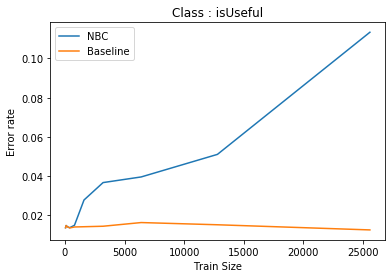

In [22]:
plt.plot(TrainSize, Error(NBCAccuracyisUseful), label = 'NBC')
plt.plot(TrainSize, Error(DefaultAccuracyisUseful), label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Error rate')
plt.title('Class : isUseful')
plt.legend()
plt.show
print(Error(NBCAccuracyisUseful))
print(Error(DefaultAccuracyisUseful))

[0.98625, 0.985125, 0.98575, 0.98625, 0.985, 0.972125, 0.96325, 0.960375, 0.948875, 0.886625]
[0.98625, 0.985125, 0.98575, 0.986375, 0.985875, 0.98575, 0.9855, 0.983625, 0.98475, 0.987375]


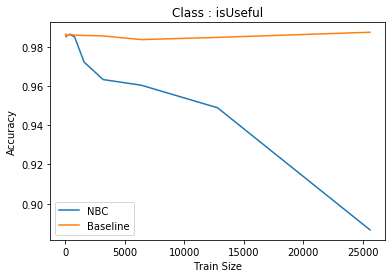

In [15]:
plt.plot(TrainSize, NBCAccuracyisUseful, label = 'NBC')
plt.plot(TrainSize, DefaultAccuracyisUseful, label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.title('Class : isUseful')
plt.legend()
plt.show
print(NBCAccuracyisUseful)
print(DefaultAccuracyisUseful)

[0.15874999999999995, 0.159875, 0.16349999999999998, 0.190125, 0.19499999999999995, 0.22562499999999996, 0.244, 0.25449999999999995, 0.25612500000000005, 0.247375]
[0.15874999999999995, 0.15837500000000004, 0.15849999999999997, 0.15674999999999994, 0.15249999999999997, 0.15849999999999997, 0.16249999999999998, 0.15449999999999997, 0.16437500000000005, 0.15749999999999997]


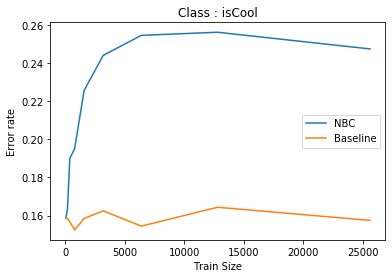

In [23]:
plt.plot(TrainSize, Error(NBCAccuracyisCool), label = 'NBC')
plt.plot(TrainSize, Error(DefaultAccuracyisCool), label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Error rate')
plt.title('Class : isCool')
plt.legend()
plt.show
print(Error(NBCAccuracyisCool))
print(Error(DefaultAccuracyisCool))

[0.84125, 0.840125, 0.8365, 0.809875, 0.805, 0.774375, 0.756, 0.7455, 0.743875, 0.752625]
[0.84125, 0.841625, 0.8415, 0.84325, 0.8475, 0.8415, 0.8375, 0.8455, 0.835625, 0.8425]


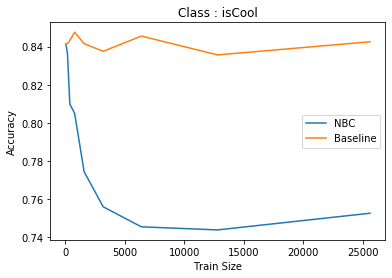

In [17]:
plt.plot(TrainSize, NBCAccuracyisCool, label = 'NBC')
plt.plot(TrainSize, DefaultAccuracyisCool, label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.title('Class : isCool')
plt.legend()
plt.show
print(NBCAccuracyisCool)
print(DefaultAccuracyisCool)

[0.35587500000000005, 0.35375, 0.34125000000000005, 0.2975, 0.29212499999999997, 0.27937500000000004, 0.25875000000000004, 0.256, 0.26175000000000004, 0.258625]
[0.35587500000000005, 0.357375, 0.359, 0.35775, 0.35487500000000005, 0.35450000000000004, 0.35450000000000004, 0.34950000000000003, 0.367, 0.35262499999999997]


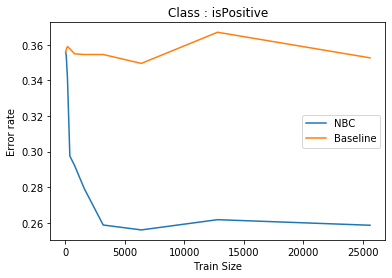

In [24]:
plt.plot(TrainSize, Error(NBCAccuracyisPositive), label = 'NBC')
plt.plot(TrainSize, Error(DefaultAccuracyisPositive), label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Error rate')
plt.title('Class : isPositive')
plt.legend()
plt.show
print(Error(NBCAccuracyisPositive))
print(Error(DefaultAccuracyisPositive))

[0.644125, 0.64625, 0.65875, 0.7025, 0.707875, 0.720625, 0.74125, 0.744, 0.73825, 0.741375]
[0.644125, 0.642625, 0.641, 0.64225, 0.645125, 0.6455, 0.6455, 0.6505, 0.633, 0.647375]


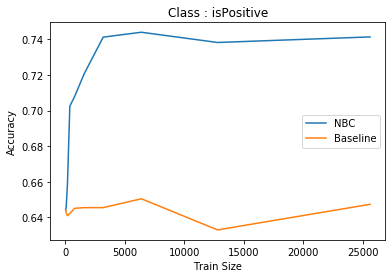

In [20]:
plt.plot(TrainSize, NBCAccuracyisPositive, label = 'NBC')
plt.plot(TrainSize, DefaultAccuracyisPositive, label = 'Baseline')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.title('Class : isPositive')
plt.legend()
plt.show
print(NBCAccuracyisPositive)
print(DefaultAccuracyisPositive)